<a href="https://colab.research.google.com/github/papagorgio23/Python101/blob/master/Retrain_F%2B_LS_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ReTrain F+ Lead Scoring Model (11/1/19)

In [ ]:
import numpy as np
import pandas as pd
import datetime
import warnings

In [ ]:
# import base packages into the namespace for this program
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier import ClassificationReport

from datetime import date 
from datetime import datetime 

# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# import base packages into the namespace for this program
import numpy as np
import pandas as pd
import os
import time

# modeling routines from Scikit Learn packages
import sklearn.linear_model 
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score  
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# obtain precision, recall, F1, and support metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score

# specify the set of classifiers being evaluated
from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

## Binning

In [ ]:
def get_co_app_cat(co_app_income):
    
    if pd.isnull(co_app_income):
        return 0
    if float(co_app_income) == 0:
        return 0
    return 1

def get_loan_use_cat(loan_use):
    
    if pd.isnull(loan_use):
        return 3
    
    loan_use = loan_use.lower().strip()
    if (loan_use == 'credit card refinancing'):
        return 4
    if (loan_use in ['major purchase','other']):
        return 2
    if (loan_use == 'auto purchase'):
        return 1
    
    return 3

def get_employment_cat(employment_status):
    
    if pd.isnull(employment_status):
        employment_status = ''
    
    employment_status = employment_status.lower().strip()
    if (employment_status == 'retired'):
        return 4
    if (employment_status in ['self-employed']):
        return 2
    if (employment_status in ['other', '']):
        return 1
    
    return 3

def get_loan_amount_cat(loan_amount):
    
    if pd.isnull(loan_amount):
        return 1
    
    loan_amount = float(loan_amount)
    if (loan_amount < 15000):
        return 4
    if (loan_amount >= 15000) and (loan_amount < 20000):
        return 3
    if (loan_amount >= 20000) and (loan_amount < 25000):
        return 2
    
    return 1

def get_mkt_chan_cat(utm_source):
    
    if pd.isnull(utm_source):
        return 3
    
    utm_source = utm_source.lower().strip()
    if (utm_source in ['creditkarma','nerdwallet']):
        return 7
    if (utm_source in ['credible','experian']):
        return 6
    if (utm_source in ['website', 'google','msn','ck','nerd',
                        '115','save','dm','slh','201']):
        return 5
    if (utm_source in ['facebook', 'even','uplift','quinstreet',
                       'personalloanpro','113']):
        return 2
    if (utm_source in ['lendedu', 'monevo','247','sfl']):
        return 1
    
    return 3

def get_fico(fico):
    
    if pd.isnull(fico):
        return 990
    
    fico = int(fico)
    if (fico >= 9000):
        return 990
    if fico < 600:
        return 990
    
    return fico

def get_lti(lti):
    
    if pd.isnull(lti):
        return 36
    
    lti = float(lti)
    if (lti > 35) or (lti < 1):
        return 36
    if (lti >= 1) and (lti < 2):
        return 35
    if (lti >= 2) and (lti < 3):
        return 34
    
    return np.floor(lti)

def get_bcc0300(bcc0300):
    
    if pd.isnull(bcc0300):
        return 99
    
    bcc0300 = int(bcc0300)
    if (bcc0300 >= 25):
        return 30
    
    return bcc0300

def get_ndi_ratio(ndi_ratio):
    
    if pd.isnull(ndi_ratio):
        return 5
    
    ndi_ratio = float(ndi_ratio)
    ndi_ratio = ndi_ratio*100
    ndi_ratio = np.floor(ndi_ratio)
    
    if (ndi_ratio < 10):
        return 5
    if (ndi_ratio > 75):
        return 80
    
    return ndi_ratio  


## Load Data

In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# set working directory
import os
os.chdir("/content/drive/My Drive/Data Scientist/F+ Lead Scoring Model/Validation/")
os.getcwd()

'/content/drive/My Drive/Data Scientist/F+ Lead Scoring Model/Validation'

In [ ]:
import numpy as np
import pandas as pd
import logging
import os
from sklearn.externals import joblib


#dirdata = os.path.join(os.path.dirname(__file__), 'Data')

global initialized
initialized = False

def init():
    
    global fplus_ls_model
    global unitEconomicsData
    
    global initialized
    if (initialized == True):
        return
    
    try:
        fplus_ls_model = joblib.load('Fplus_Lead_Scoring')
        unitEconomicsData = pd.read_csv('unitEconomicsData.csv')
        #fplus_ls_model = joblib.load(os.path.join(dirdata, 'Fplus_Lead_Scoring'))
        #unitEconomicsData = pd.read_csv(os.path.join(dirdata, 'unitEconomicsData.csv'))
        
    except Exception as e:
        #print(e)
        return
    
    initialized = True


/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [ ]:
init()

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.19.1 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [ ]:
# load data
df = pd.read_csv('full_data.csv')
df.head()

,SF_App_Id,SF_App_Date_TS,Funding_Score,Funding_Model_Segment,NPV_Score,NPV_Model_Segment,Funding,NPV_Actual,name,loan_application_id,lead_type__c,createddate,prequal_submitted_date__c,full_app_submitted_date__c,Loan_Officer_Assigned,date_funded__c,funded_flag,loan_officer_name__c,amount_of_loan_requested__c,first_amount_of_loan_requested,verifiable_annual_income__c,first_income_p1,co_app_verifiable_annual_income__c,first_income_p2,co_app,first_coapp,income_sum,first_income_sum,c_LTI,First_LTI,loan_use__c,first_loan_use,employment_status__c,ndi_ratio__c,first_ndi_ratio__c,fico__c,first_FICO,utm_source__c,bcc0300__c,first_bcc0300__c,interest_rate__c,risk_group__c,final_risk_group__c,risk_group_p1__c,NPV_Actual_Funded,NPV_Score_Funded,delta_coapp,delta_LTI,delta_NDI,delta_FICO,delta_loan_size,delta_bcc0300
0,a010f00000Vy85MAAR,2019-04-08 23:29:35,9.801852e-08,10,NaN,10,0,NaN,App-04315517,NaN,Web,2019-04-08 23:29:35,NaN,NaN,1.0,NaN,0.0,Adrian Quinonez,NaN,22000.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.441415,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
1,a010f00000WN27oAAD,2019-04-29 13:24:25,6.886856e-01,1,53.655499,3,1,77.91,App-04502943,3364269.0,Web,2019-04-29 13:24:25,2019-04-29 13:24:27,2019-04-29 18:30:36,1.0,2019-04-30,1.0,Casey Mamoe,10000.0,10000.0,11856.0,62000.0,55000.0,10000.0,1.0,1.0,66856.0,72000.0,0.149575,0.138889,Credit Card Refinancing,Debt Consolidation,Retired,62.3,0.457451,678.0,653.0,115,9.0,9.0,13.49,1.0,1.0,1.0,77.91,53.655499,0.0,-0.010686,-61.842549,-25.0,0.0,0.0
2,a010f00000Tq9b3AAB,2019-02-27 22:42:24,8.452948e-02,4,72.941334,2,0,0.00,App-03960803,3010059.0,Web,2019-02-27 22:42:24,2019-02-27 22:42:25,NaN,1.0,NaN,0.0,Jamie Boldt,20000.0,20000.0,70000.0,70000.0,NaN,NaN,0.0,0.0,70000.0,70000.0,0.285714,0.285714,Debt Consolidation,Debt Consolidation,Retired,29.0,0.290281,719.0,719.0,115,9.0,9.0,NaN,4.0,4.0,NaN,NaN,72.941334,0.0,0.000000,-28.709719,0.0,0.0,0.0
3,a010f00000WSBY6AAP,2019-05-02 23:32:29,5.279838e-01,1,41.135220,3,0,0.00,App-04548298,3390695.0,Web,2019-05-02 23:32:29,2019-05-02 23:32:31,NaN,1.0,NaN,0.0,Amanda Fuller,10000.0,10000.0,60000.0,60000.0,12000.0,12000.0,1.0,1.0,72000.0,72000.0,0.138889,0.138889,Other,Other,Full-time,44.6,0.446276,655.0,655.0,115,3.0,3.0,NaN,12.0,12.0,NaN,NaN,41.135220,0.0,0.000000,-44.153724,0.0,0.0,0.0
4,a010f00000WsXcoAAF,2019-05-30 01:40:30,4.749825e-01,1,409.867184,1,0,0.00,App-04816148,1434836.0,Web,2019-05-30 01:40:30,2019-05-30 01:40:32,NaN,1.0,NaN,0.0,Ervin Ramos,20000.0,20000.0,60000.0,60000.0,76000.0,76000.0,1.0,1.0,136000.0,136000.0,0.147059,0.147059,Debt Consolidation,Debt Consolidation,Retired,28.1,0.281249,706.0,706.0,115,12.0,11.0,NaN,3.0,3.0,NaN,NaN,409.867184,0.0,0.000000,-27.818751,0.0,0.0,-1.0


## Get First Variables

In [ ]:
first_var = ['Funding', 'first_coapp', 'first_loan_use',\
            'employment_status__c', 'first_amount_of_loan_requested', 'first_FICO', \
            'First_LTI', 'first_bcc0300__c', 'first_ndi_ratio__c', 'utm_source__c']

In [ ]:
first_df = df[first_var]

In [ ]:
first_df.head()

,Funding,first_coapp,first_loan_use,employment_status__c,first_amount_of_loan_requested,first_FICO,First_LTI,first_bcc0300__c,first_ndi_ratio__c,utm_source__c
0,0,0.0,NaN,NaN,22000.0,NaN,NaN,NaN,0.441415,NaN
1,1,1.0,Debt Consolidation,Retired,10000.0,653.0,0.138889,9.0,0.457451,115
2,0,0.0,Debt Consolidation,Retired,20000.0,719.0,0.285714,9.0,0.290281,115
3,0,1.0,Other,Full-time,10000.0,655.0,0.138889,3.0,0.446276,115
4,0,1.0,Debt Consolidation,Retired,20000.0,706.0,0.147059,11.0,0.281249,115


## Change Strings to lowercase

In [ ]:
first_df.describe()

,Funding,first_coapp,first_amount_of_loan_requested,first_FICO,First_LTI,first_bcc0300__c,first_ndi_ratio__c
count,250749.000000,249300.000000,248982.000000,246023.000000,248783.000000,247246.000000,244729.000000
mean,0.090752,0.153987,22188.402152,714.127659,0.237029,7.661899,0.378429
std,0.287257,0.360937,11604.587842,111.537659,0.150290,5.353731,0.149598
min,0.000000,0.000000,2500.000000,431.000000,0.000014,0.000000,0.000036
25%,0.000000,0.000000,13000.000000,676.000000,0.150000,4.000000,0.279837
50%,0.000000,0.000000,20000.000000,707.000000,0.210526,6.000000,0.367693
75%,0.000000,0.000000,30000.000000,745.000000,0.291667,10.000000,0.470779
max,1.000000,1.000000,288000.000000,9003.000000,18.000000,99.000000,23.000656


## Transform Variables

In [ ]:
# Transform variables
first_df['co_app'] = first_df['first_coapp'].apply(get_co_app_cat)
first_df['loan_use'] = first_df['first_loan_use'].apply(get_loan_use_cat)
first_df['employment'] = first_df['employment_status__c'].apply(get_employment_cat)
first_df['loan_amount'] = first_df['first_amount_of_loan_requested'].apply(get_loan_amount_cat)
first_df['mkt_chan'] = first_df['utm_source__c'].apply(get_mkt_chan_cat)
first_df['ficox'] = first_df['first_FICO'].apply(get_fico)
first_df['lti'] = first_df['First_LTI'].apply(get_lti)
first_df['bcc0300'] = first_df['first_bcc0300__c'].apply(get_bcc0300)
first_df['ndi'] = first_df['first_ndi_ratio__c'].apply(get_ndi_ratio)
first_df['ndisq'] = first_df['ndi'] * first_df['ndi']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [ ]:
first_df.describe()

,Funding,first_coapp,first_amount_of_loan_requested,first_FICO,First_LTI,first_bcc0300__c,first_ndi_ratio__c,co_app,loan_use,employment,loan_amount,mkt_chan,ficox,lti,bcc0300,ndi,ndisq
count,250749.000000,249300.000000,248982.000000,246023.000000,248783.000000,247246.000000,244729.000000,250749.000000,250749.000000,250749.000000,250749.000000,250749.000000,250749.000000,250749.000000,250749.000000,250749.000000,250749.000000
mean,0.090752,0.153987,22188.402152,714.127659,0.237029,7.661899,0.378429,0.153097,3.077755,2.855704,2.409784,2.977448,718.547300,35.995513,8.926572,36.564864,1555.065412
std,0.287257,0.360937,11604.587842,111.537659,0.150290,5.353731,0.149598,0.360082,0.699135,0.537598,1.241502,0.819330,61.711415,0.240157,11.898910,14.767431,1139.654821
min,0.000000,0.000000,2500.000000,431.000000,0.000014,0.000000,0.000036,0.000000,1.000000,1.000000,1.000000,1.000000,600.000000,3.000000,0.000000,5.000000,25.000000
25%,0.000000,0.000000,13000.000000,676.000000,0.150000,4.000000,0.279837,0.000000,3.000000,3.000000,1.000000,3.000000,676.000000,36.000000,4.000000,27.000000,729.000000
50%,0.000000,0.000000,20000.000000,707.000000,0.210526,6.000000,0.367693,0.000000,3.000000,3.000000,2.000000,3.000000,709.000000,36.000000,7.000000,36.000000,1296.000000
75%,0.000000,0.000000,30000.000000,745.000000,0.291667,10.000000,0.470779,0.000000,4.000000,3.000000,4.000000,3.000000,748.000000,36.000000,10.000000,46.000000,2116.000000
max,1.000000,1.000000,288000.000000,9003.000000,18.000000,99.000000,23.000656,1.000000,4.000000,4.000000,4.000000,7.000000,990.000000,36.000000,99.000000,80.000000,6400.000000


In [ ]:
first_df.columns

Index(['Funding', 'first_coapp', 'first_loan_use', 'employment_status__c',
       'first_amount_of_loan_requested', 'first_FICO', 'First_LTI',
       'first_bcc0300__c', 'first_ndi_ratio__c', 'utm_source__c', 'co_app',
       'loan_use', 'employment', 'loan_amount', 'mkt_chan', 'ficox', 'lti',
       'bcc0300', 'ndi', 'ndisq'],
      dtype='object')

In [ ]:
first_df

,Funding,first_coapp,first_loan_use,employment_status__c,first_amount_of_loan_requested,first_FICO,First_LTI,first_bcc0300__c,first_ndi_ratio__c,utm_source__c,ficox,lti,bcc0300,ndi,ndisq,co_app_0,co_app_1,loan_use_1,loan_use_2,loan_use_3,loan_use_4,employment_1,employment_2,employment_3,employment_4,loan_amount_1,loan_amount_2,loan_amount_3,loan_amount_4,mkt_chan_1,mkt_chan_2,mkt_chan_3,mkt_chan_5,mkt_chan_6,mkt_chan_7
0,0,0.0,NaN,NaN,22000.0,NaN,NaN,NaN,0.441415,NaN,990,36.0,99,44.0,1936.0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0
1,1,1.0,Debt Consolidation,Retired,10000.0,653.0,0.138889,9.0,0.457451,115,653,36.0,9,45.0,2025.0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0
2,0,0.0,Debt Consolidation,Retired,20000.0,719.0,0.285714,9.0,0.290281,115,719,36.0,9,29.0,841.0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0
3,0,1.0,Other,Full-time,10000.0,655.0,0.138889,3.0,0.446276,115,655,36.0,3,44.0,1936.0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0
4,0,1.0,Debt Consolidation,Retired,20000.0,706.0,0.147059,11.0,0.281249,115,706,36.0,11,28.0,784.0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250744,1,0.0,Major Purchase,Full-time,10000.0,659.0,0.200000,4.0,0.503917,yahoo,659,36.0,4,50.0,2500.0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0
250745,0,0.0,Debt Consolidation,Retired,40000.0,706.0,0.714286,2.0,0.671361,yahoo,706,36.0,2,67.0,4489.0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0
250746,0,0.0,Debt Consolidation,Retired,10000.0,641.0,0.222222,4.0,0.457051,yahoo,641,36.0,4,45.0,2025.0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0
250747,1,0.0,Credit Card Refinancing,Full-time,20000.0,658.0,0.121951,22.0,0.246806,yahoo,658,36.0,22,24.0,576.0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0


In [ ]:
# create dummies
cat_vars = ['co_app','loan_use','employment','loan_amount','mkt_chan']
for var in cat_vars:
    cat_list = pd.get_dummies(first_df[var], prefix=var)
    temp = first_df.join(cat_list)
    first_df = temp
data_vars = first_df.columns.values.tolist()
to_keep = [i for i in data_vars if i not in cat_vars]
first_df = first_df[to_keep]

In [ ]:
first_df.columns

Index(['Funding', 'first_coapp', 'first_loan_use', 'employment_status__c',
       'first_amount_of_loan_requested', 'first_FICO', 'First_LTI',
       'first_bcc0300__c', 'first_ndi_ratio__c', 'utm_source__c', 'ficox',
       'lti', 'bcc0300', 'ndi', 'ndisq', 'co_app_0', 'co_app_1', 'loan_use_1',
       'loan_use_2', 'loan_use_3', 'loan_use_4', 'employment_1',
       'employment_2', 'employment_3', 'employment_4', 'loan_amount_1',
       'loan_amount_2', 'loan_amount_3', 'loan_amount_4', 'mkt_chan_1',
       'mkt_chan_2', 'mkt_chan_3', 'mkt_chan_5', 'mkt_chan_6', 'mkt_chan_7'],
      dtype='object')

In [ ]:
# re-index to have same columns as the model
first_df_indexed = first_df.reindex(columns = ['Funding', 'ficox', 'lti', 'bcc0300', 'ndi', 'ndisq', 'co_app_0', 'co_app_1',
                               'loan_use_1', 'loan_use_2', 'loan_use_3', 'loan_use_4', 'employment_1',
                               'employment_2', 'employment_3', 'employment_4', 'loan_amount_1',
                               'loan_amount_2', 'loan_amount_3', 'loan_amount_4', 'mkt_chan_1',
                               'mkt_chan_2', 'mkt_chan_3', 'mkt_chan_5', 'mkt_chan_6', 
                               'mkt_chan_7'], fill_value=0)

In [ ]:
first_df_indexed

,Funding,ficox,lti,bcc0300,ndi,ndisq,co_app_0,co_app_1,loan_use_1,loan_use_2,loan_use_3,loan_use_4,employment_1,employment_2,employment_3,employment_4,loan_amount_1,loan_amount_2,loan_amount_3,loan_amount_4,mkt_chan_1,mkt_chan_2,mkt_chan_3,mkt_chan_5,mkt_chan_6,mkt_chan_7
0,0,990,36.0,99,44.0,1936.0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0
1,1,653,36.0,9,45.0,2025.0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0
2,0,719,36.0,9,29.0,841.0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0
3,0,655,36.0,3,44.0,1936.0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0
4,0,706,36.0,11,28.0,784.0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250744,1,659,36.0,4,50.0,2500.0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0
250745,0,706,36.0,2,67.0,4489.0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0
250746,0,641,36.0,4,45.0,2025.0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0
250747,1,658,36.0,22,24.0,576.0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0


## Split Data

In [ ]:
# segment out the variable we are predicting from the rest of the data
y = first_df_indexed['Funding']
X = first_df_indexed.drop(['Funding'], axis = 1)
print(X.shape, y.shape)

(250749, 25) (250749,)


In [ ]:
# Split the data into a train and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(200599, 25) (200599,)
(50150, 25) (50150,)


In [ ]:
print(y_train.mean())
print(y_test.mean())

0.09070832855597485
0.0909272183449651


## Train Model

In [ ]:
import numpy as np
import pandas as pd
from datetime import date 

# Pretty print a confusion matrixes rows actual, columns predicted
# Adapted from: https://gist.github.com/zachguo/10296432
def print_cm(cm, labels, hide_zeroes=False, hide_diagonal=False, 
             hide_threshold=None):
    """pretty print for confusion matrixes"""
    columnwidth = max([len(x) for x in labels] + [5])  # 5 is value length
    empty_cell = " " * columnwidth
    # Print header
    print("    " + empty_cell, end=" ")
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end=" ")
    print()
    # Print rows
    for i, label1 in enumerate(labels):
        print("    %{0}s".format(columnwidth) % label1, end=" ")
        for j in range(len(labels)):
            cell = "%{0}.0f".format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            print(cell, end=" ")
        print()

In [ ]:
classes = ['Not Funded', 'Funded']

In [ ]:
# wall-clock time at beginning of modeling work
start_time = time.clock()  

classifier = LogisticRegression()
classifier.fit(X_train, y_train)  
# evaluate on the test set for this fold
y_final_test_logit_predict_prob = classifier.predict_proba(X_test)
y_final_test_logit_predict = classifier.predict(X_test)

print('Area under ROC curve:', roc_auc_score(y_test, y_final_test_logit_predict_prob[:,1]))

print('\nLogistic Regression Confusion Matrix',
      '(rows actual, columns predicted)\n')
print_cm(confusion_matrix(y_test.values, 
                 y_final_test_logit_predict),
                 labels = classes)

print('\nLogistic Regression Accuracy: ',                
np.round(accuracy_score(y_test.values, 
               y_final_test_logit_predict), decimals = 3))
          
print()

end_time = time.clock()  # wall-clock time at end of modeling work
runtime = end_time - start_time  # seconds of wall-clock time 
print('\nLogistic Regression classification elapsed time (seconds):', 
      np.round(runtime, decimals = 3))

print('\nRUN COMPLETE')    

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Area under ROC curve: 0.7120207546861231

Logistic Regression Confusion Matrix (rows actual, columns predicted)

               Not Funded     Funded 
    Not Funded      45572         18 
        Funded       4553          7 

Logistic Regression Accuracy:  0.909


Logistic Regression classification elapsed time (seconds): 2.598

RUN COMPLETE


## Plot Predictions

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


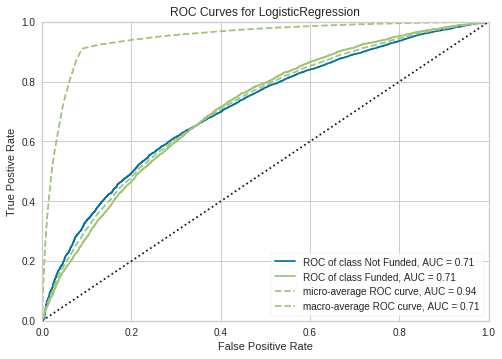

In [ ]:
# Set classes for all plots
classes = ['Not Funded', 'Funded']

classifier = LogisticRegression()

# Instantiate the visualizer with the classification model
visualizer = ROCAUC(classifier, classes=classes)


visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()

# Anita's Validation Dataset

In [ ]:
ls

 final_df.csv                   library_binning.py   score_collector_phase1.py
 first_df.csv                   main_leadLevel.py    scoringData.py
 Fplus_Lead_Scoring             model.py             unitEconomicsData.csv
 fplus_ls_201910_validate.csv   __pycache__/        'Validation F+ Model.ipynb'
 full_data.csv                  Retrain_Fplus.csv


In [ ]:
val_data = pd.read_csv("fplus_ls_201910_validate.csv")  

In [ ]:
val_data.head()

,Unnamed: 0,Id,CreateDatex,utm_source__c,Final_Loan_Amount__c,Amount_of_Loan_Requested__c,Loan_Use__c,Co_App_Verifiable_Annual_Income_,employment_status__c,fico__c,lti__c,bcc0300__c,ndi_ratio__c,Funding,Actual_NPV,co_app,Loan_Use,employment,loan_amount,ficox,lti,bcc0300,ndi,ndisq,mkt_chan,F_Funding,I_Funding,P_0,P_1,CPA,NPV_Pred
0,1,a010f00000TqviPAAR,1835290126,115,20000.00,20000,Home Improvement,25000.0,Self-employed,671.0,23.5,8.0,0.326,0,0.0,1,3,2,2,671,23,8,32,1024,5,0,0,0.867707,0.132293,NaN,114.156631
1,2,a010f00000Tqlc9AAB,1835050177,crowdnetic,20900.00,30000,Debt Consolidation,0.0,Full-time,753.0,34.9,14.0,0.523,0,0.0,0,3,3,1,753,34,14,52,2704,3,0,0,0.985418,0.014582,367.64,18.668359
2,3,a010f00000Tr3BdAAJ,1835390346,crowdnetic,15000.00,18000,Credit Card Refinancing,42000.0,Part-time,717.0,28.6,13.0,0.399,1,264.0,1,4,3,3,717,28,13,39,1521,3,1,0,0.895348,0.104652,367.64,35.400666
3,4,a010f00000TrQgSAAV,1835830152,crowdnetic,24500.00,25000,Debt Consolidation,0.0,Retired,700.0,35.0,21.0,0.430,0,0.0,0,3,4,1,700,35,21,43,1849,3,0,0,0.972221,0.027779,367.64,24.661464
4,5,a010f00000ThnKUAAZ,1834417434,crowdnetic,19999.99,40000,Home Improvement,0.0,Full-time,825.0,33.3,4.0,0.453,0,0.0,0,3,3,1,825,33,4,45,2025,3,0,0,0.982591,0.017409,367.64,35.953581


##Transform Data

In [ ]:
val_data.columns

Index(['Unnamed: 0', 'Id', 'CreateDatex', 'utm_source__c',
       'Final_Loan_Amount__c', 'Amount_of_Loan_Requested__c', 'Loan_Use__c',
       'Co_App_Verifiable_Annual_Income_', 'employment_status__c', 'fico__c',
       'lti__c', 'bcc0300__c', 'ndi_ratio__c', 'Funding', 'Actual_NPV',
       'co_app', 'Loan_Use', 'employment', 'loan_amount', 'ficox', 'lti',
       'bcc0300', 'ndi', 'ndisq', 'mkt_chan', 'F_Funding', 'I_Funding', 'P_0',
       'P_1', 'CPA', 'NPV_Pred'],
      dtype='object')

In [ ]:
val_data['loan_use'] = val_data['Loan_Use']

In [ ]:
# create dummies
cat_vars = ['co_app','loan_use','employment','loan_amount','mkt_chan']
for var in cat_vars:
    cat_list = pd.get_dummies(val_data[var], prefix=var)
    temp = val_data.join(cat_list)
    val_data = temp
data_vars = val_data.columns.values.tolist()
to_keep = [i for i in data_vars if i not in cat_vars]
val_data = val_data[to_keep]

In [ ]:
val_data.columns

Index(['Unnamed: 0', 'Id', 'CreateDatex', 'utm_source__c',
       'Final_Loan_Amount__c', 'Amount_of_Loan_Requested__c', 'Loan_Use__c',
       'Co_App_Verifiable_Annual_Income_', 'employment_status__c', 'fico__c',
       'lti__c', 'bcc0300__c', 'ndi_ratio__c', 'Funding', 'Actual_NPV',
       'Loan_Use', 'ficox', 'lti', 'bcc0300', 'ndi', 'ndisq', 'F_Funding',
       'I_Funding', 'P_0', 'P_1', 'CPA', 'NPV_Pred', 'co_app_0', 'co_app_1',
       'loan_use_1', 'loan_use_2', 'loan_use_3', 'loan_use_4', 'employment_1',
       'employment_2', 'employment_3', 'employment_4', 'loan_amount_1',
       'loan_amount_2', 'loan_amount_3', 'loan_amount_4', 'mkt_chan_1',
       'mkt_chan_2', 'mkt_chan_3', 'mkt_chan_5', 'mkt_chan_7'],
      dtype='object')

In [ ]:
# re-index to have same columns as the model
val_data_indexed = val_data.reindex(columns = ['ficox', 'lti', 'bcc0300', 'ndi', 'ndisq', 'co_app_0', 'co_app_1',
                               'loan_use_1', 'loan_use_2', 'loan_use_3', 'loan_use_4', 'employment_1',
                               'employment_2', 'employment_3', 'employment_4', 'loan_amount_1',
                               'loan_amount_2', 'loan_amount_3', 'loan_amount_4', 'mkt_chan_1',
                               'mkt_chan_2', 'mkt_chan_3', 'mkt_chan_5', 'mkt_chan_6', 
                               'mkt_chan_7'], fill_value=0)

In [ ]:
val_data_predictions = classifier.predict(val_data_indexed)
val_data_prob_pred = classifier.predict_proba(val_data_indexed)

In [ ]:
val_data_predictions.shape

(100,)

In [ ]:
val_data['NewScore'] = val_data_prob_pred[:,1]

In [ ]:
val_data.to_csv('val_data.csv', index=False)

#Deep Learning

In [ ]:
import keras
from keras import models
from keras import layers
from keras.optimizers import SGD, RMSprop, Adam

In [ ]:
X_train.shape[1]

25

In [ ]:
# Create parameter variables for training
batch_size = 25000
num_classes = 2
epochs = 25

model = models.Sequential(name="Neural_Network_1")
model.add(layers.Dense(15, activation='relu', input_shape=(X_train.shape[1],), name="Hidden_Layer1"))
#model.add(layers.Dense(10,activation="relu", name="Hidden_Layer2"))
model.add(layers.Dense(1, activation='sigmoid', name = "Funding"))
model.compile(optimizer='SGD',
              loss='kullback_leibler_divergence',
              metrics=['accuracy'])

model.summary()

Model: "Neural_Network_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Hidden_Layer1 (Dense)        (None, 15)                390       
_________________________________________________________________
Funding (Dense)              (None, 1)                 16        
Total params: 406
Trainable params: 406
Non-trainable params: 0
_________________________________________________________________


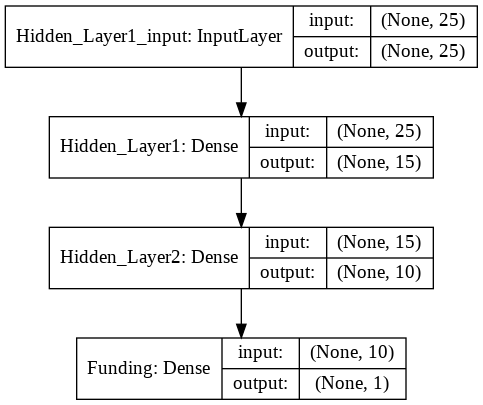

In [ ]:
from keras.utils import plot_model
#plot_model(model, to_file='model.png')
plot_model(model, show_layer_names=True, show_shapes=True, expand_nested=True)

In [ ]:
# Train the NN & record the time
warnings.filterwarnings('ignore')
start = datetime.datetime.now()

history_one = model.fit(X_train,
                        y_train, 
                        validation_data = (X_test,y_test), 
                        validation_split=0.8,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1)

end = datetime.datetime.now()
time_diff = end-start
print('Time to train = {}'.format(time_diff))

Train on 200599 samples, validate on 50150 samples
Epoch 1/25
200599/200599 [==============================] - 1s 6us/step - loss: 1.4620 - acc: 0.9093 - val_loss: 1.4656 - val_acc: 0.9091
Epoch 2/25
200599/200599 [==============================] - 0s 1us/step - loss: 1.4620 - acc: 0.9093 - val_loss: 1.4656 - val_acc: 0.9091
Epoch 3/25
200599/200599 [==============================] - 0s 1us/step - loss: 1.4620 - acc: 0.9093 - val_loss: 1.4656 - val_acc: 0.9091
Epoch 4/25
200599/200599 [==============================] - 0s 1us/step - loss: 1.4620 - acc: 0.9093 - val_loss: 1.4656 - val_acc: 0.9091
Epoch 5/25
200599/200599 [==============================] - 0s 1us/step - loss: 1.4620 - acc: 0.9093 - val_loss: 1.4656 - val_acc: 0.9091
Epoch 6/25
200599/200599 [==============================] - 0s 1us/step - loss: 1.4620 - acc: 0.9093 - val_loss: 1.4656 - val_acc: 0.9091
Epoch 7/25
200599/200599 [==============================] - 0s 1us/step - loss: 1.4620 - acc: 0.9093 - val_loss: 1.4656 -